# El Salvador Tree Cover EDA with Rasterio

**Useful links**
- https://rasterio.readthedocs.io/en/latest/quickstart.html
- https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
- https://www.hatarilabs.com/ih-en/how-to-clip-sentinel-2-bands-to-a-area-of-interest-with-python-rasterio-and-fiona-tutorial

**Data**  
- sentinel_treecover.tif (10m resolution)
- hansen_treecover.tif (30m resolution)
- *.geojson - subnational jurisdictions
- [ESA LC tif](http://maps.elie.ucl.ac.be/CCI/viewer/download.php): 2015 global land cover map at 300 m spatial resolution.

# Data Preparation

In [1]:
import os
import rasterio as rs
from rasterio.mask import mask
from rasterio.plot import show, show_hist, adjust_band
from rasterio.enums import Resampling
from rasterio import Affine, MemoryFile

import numpy as np 
import numpy.ma as ma 
import seaborn as sns
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd 
import pandas as pd
import fiona
from contextlib import contextmanager  
from skimage.transform import resize

%matplotlib inline

In [18]:
rs.__version__

'1.1.5'

## Clip and Resample Rasters
Masking and resampling with Rasterio. In the future, the ESA data tiles will match perfectly to TOF, so won't need resample.
- https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439
- https://gis.stackexchange.com/questions/337627/python-mask-raster-array-using-shapefile-or-rasterio

In [2]:
tof_data = rs.open("El Salvador/sentinel_treecover.tif")
hansen_data = rs.open("El Salvador/hansen_treecover.tif")
esa_data = rs.open('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif')
jurisdictions = gpd.read_file('El Salvador/elsalvador_adm2.geojson')

In [2]:
def clip_raster(country, shapefile):
    
    '''
    Function takes in a tof/hansen raster for a country, masks out admin 1 boundaries 
    based on the country's shapefile and then writes each masked raster to individual files. 
    '''
    
    tof_raster = rs.open(f'{country}/sentinel_treecover.tif') # needs to be updated based on filepath
    hansen_raster = rs.open(f'{country}/hansen_treecover.tif')
    esa_raster = rs.open('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif')
    
    if not os.path.exists(f'{country}/clipped_rasters/hansen'):
        os.makedirs(f'{country}/clipped_rasters/hansen')
    
    if not os.path.exists(f'{country}/clipped_rasters/tof'):
        os.makedirs(f'{country}/clipped_rasters/tof')
    
    if not os.path.exists(f'{country}/clipped_rasters/esa'):
        os.makedirs(f'{country}/clipped_rasters/esa')
    
    for geo, juris in zip(shapefile.geometry, shapefile.ADM2_ES):
        
            # clip tof rasters
            out_img_tof, out_transform_tof = mask(dataset=tof_raster, shapes=geo, crop=True)
            out_meta_tof = tof_raster.meta
            out_meta_tof.update({'driver': 'GTiff',    
                                 'dtype': 'uint8',
                                 'height': out_img_tof.shape[1],
                                 'width': out_img_tof.shape[2],
                                 'transform': out_transform_tof})

            outpath_tof = f'{country}/clipped_rasters/tof/{juris}.tif'
            with rs.open(outpath_tof, "w", **out_meta_tof) as dest:
                dest.write(out_img_tof)
                
            # clip hansen rasters
            out_img_han, out_transform_han = mask(dataset=hansen_raster, shapes=geo, crop=True)
            out_meta_han = hansen_raster.meta
            out_meta_han.update({'driver': 'GTiff',    
                                 'dtype': 'uint8',
                                 'height': out_img_han.shape[1],
                                 'width': out_img_han.shape[2],
                                 'transform': out_transform_han})

            outpath_han = f'{country}/clipped_rasters/hansen/{juris}.tif'
            with rs.open(outpath_han, "w", **out_meta_han) as dest:
                dest.write(out_img_han)
            
            # clip esa rasters
            out_img_esa, out_transform_esa = mask(dataset=esa_raster, shapes=geo, crop=True)
            out_meta_esa = esa_raster.meta
            out_meta_esa.update({'driver': 'GTiff',    
                                 'dtype': 'uint8',
                                 'height': out_img_esa.shape[1],
                                 'width': out_img_esa.shape[2],
                                 'transform': out_transform_esa})

            outpath_esa = f'{country}/clipped_rasters/esa/{juris}.tif'
            with rs.open(outpath_esa, "w", **out_meta_esa) as dest:
                dest.write(out_img_esa)
           
    return f"{country}'s rasters clipped and saved."

In [3]:
def resample_raster(country, jurisdiction_list, data, scale):
    
    '''
    Function takes in a clipped raster and resamples to convert to higher 
    resolution, then writes the masked raster to a new file.

    Resampling a raster involves multiplying the pixel size by the scale factor 
    and dividing the dimensions by the scale factor. A scale >1 is an upsample
    and a scale <1: downsample.

        i.e. given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
        the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
    '''
    
    if not os.path.exists(f'{country}/resampled_rasters/hansen'):
        os.makedirs(f'{country}/resampled_rasters/hansen')
    
    if not os.path.exists(f'{country}/resampled_rasters/tof'):
        os.makedirs(f'{country}/resampled_rasters/tof')
    
    if not os.path.exists(f'{country}/resampled_rasters/esa'):
        os.makedirs(f'{country}/resampled_rasters/esa')
    
    for juris in jurisdiction_list:
        
        inpath = f'{country}/clipped_rasters/{data}/{juris}.tif'
        outpath = f'{country}/resampled_rasters/{data}/{juris}.tif'
        raster = rs.open(inpath)
        height = int(raster.height)
        width = int(raster.width)
        
        # resample data to target shape -- use Resampling.nearest not Resampling.bilinear
        resampled = raster.read(out_shape=(raster.count, (height * scale), (width * scale)),
                                resampling=Resampling.nearest)
        
        # removes extra index
        resampled = resampled.squeeze()
        
        # scale image transform
        transform = raster.transform * raster.transform.scale((width / resampled.shape[-1]),
                                                              (height / resampled.shape[-2]))
        
        new_dataset = rs.open(outpath, 'w', 
                              driver='GTiff',
                              height=resampled.shape[0], 
                              width=resampled.shape[1], 
                              count=1,
                              dtype="uint8",
                              crs='+proj=longlat +datum=WGS84 +no_defs',
                              transform=transform)
        
        new_dataset.write(resampled, 1)
        new_dataset.close()
        
    # Reopen as DatasetReader
    dataset = rs.open(outpath)
    return dataset

In [5]:
jurisdictions = gpd.read_file('El Salvador/elsalvador_adm2.geojson')

In [7]:
clip_raster('El Salvador', jurisdictions)

"El Salvador's rasters clipped and saved."

In [8]:
resample_raster('El Salvador', list(jurisdictions.ADM2_ES), 'tof', 1) # tof not resampled
resample_raster('El Salvador', list(jurisdictions.ADM2_ES), 'hansen', 3) # hansen upsampled 30 -> 10m scale
resample_raster('El Salvador', list(jurisdictions.ADM2_ES), 'esa', 30) # esa upsampled 300 -> 10m scale

<open DatasetReader name='El Salvador/resampled_rasters/esa/Sonzacate.tif' mode='r'>

# Tree Cover Stats

In [6]:
def prepare_data(raster): 
    
    '''
    Reshapes a raster by rounding down to the nearest 10th and 
    reshaping to a 10x10 grid, returns reshaped array.
    '''
    
    def round_down(num, divisor):
         return num - (num%divisor)

    # round down rows and cols to nearest 10th
    rows, cols = round_down(raster.shape[0], 10), round_down(raster.shape[1], 10)

    # clip according to rounded numbers and reshape
    rounded = raster[:rows, :cols]
    reshaped = np.reshape(rounded, (int(rounded.shape[0] / 10), 10, int(rounded.shape[1] / 10), 10))

    return reshaped


In [7]:
def hansen_v_tof(country, jurisdiction_list):
    
    '''
    Calculates mean tree cover and total hectares with >10% tree
    cover per jurisdiction for tof and hansen rasters, saves
    statistics to a csv file and returns a pandas dataframe.
    '''
    
    tree_cover = pd.DataFrame(columns=['jurisdiction', 
                                       'tof_mean_tc', 
                                       'tof_total_ha',
                                       'hansen_mean_tc', 
                                       'hansen_total_ha'])
    
    for juris in jurisdiction_list:
        
        tof = rs.open(f'{country}/resampled_rasters/tof/{juris}.tif').read(1)
        hansen = rs.open(f'{country}/resampled_rasters/hansen/{juris}.tif').read(1)

        tof_reshaped = prepare_data(tof)
        hansen_reshaped = prepare_data(hansen)
        
        # calculate mean tree cover for the jurisdiction
        tof_tc = round(np.mean(tof_reshaped), 3)   
        hansen_tc = round(np.mean(hansen_reshaped), 3)   

        # calculate mean tree cover for each hectare
        tof_tc_ha = np.mean(tof_reshaped, axis=(1,3)) 
        hansen_tc_ha = np.mean(hansen_reshaped, axis=(1,3)) 
        
        # calculate the num of hectares with mean tree cover >10%
        tof_ha_over10 = np.sum(tof_tc_ha > 10) 
        hansen_ha_over10 = np.sum(hansen_tc_ha > 10) 

        tree_cover = tree_cover.append({'jurisdiction': juris, 
                                        'tof_mean_tc': tof_tc, 
                                        'tof_total_ha': tof_ha_over10,
                                        'hansen_mean_tc': hansen_tc, 
                                        'hansen_total_ha': hansen_ha_over10}, ignore_index=True)
        
        tree_cover['tof_hans'] = tree_cover['tof_total_ha'] - tree_cover['hansen_total_ha']
        
        tree_cover.to_csv(f"{country}/{country}-tof-hansen-stats.csv")
    
    return tree_cover

In [188]:
tvh = hansen_v_tof('El Salvador', list(jurisdictions.ADM2_ES))
tvh.head()

,jurisdiction,tof_mean_tc,tof_total_ha,hansen_mean_tc,hansen_total_ha,tof_hans
0,Apaneca,61.411,3712,57.467,4481,-769
1,Concepción de Ataco,61.418,6281,58.504,7555,-1274
2,Guaymango,27.645,9031,12.511,6376,2655
3,Jujutla,26.606,16974,14.555,12873,4101
4,San Pedro Puxtla,25.477,2058,17.245,1688,370


# Tree Cover Stats per Land Cover Class

In [9]:
def land_cover_stats(country, jurisdiction_list):
    
    '''
    Calculates tree cover statistics per admin 1 boundary and ESA land cover 
    class for tof and hansen rasters. Returns a dataframe with the jurisdiction, 
    ESA land cover id and class name, mean tree cover and total hectares with >10% tree
    cover.
    '''
    
    tree_cover = pd.DataFrame(columns=['jurisdiction', 
                                       'esa_id', 
                                       'lc_class',
                                       'ipcc_class',
                                       'tof_mean_tc', 
                                       'tof_total_ha', 
                                       'hansen_mean_tc',
                                       'hansen_total_ha',
                                       'tof_hans'])
    
    for juris in jurisdiction_list:
        
        # resize esa to tof boundaries then reshape both
        esa = rs.open(f'{country}/resampled_rasters/esa/{juris}.tif').read(1)
        tof = rs.open(f'{country}/resampled_rasters/tof/{juris}.tif').read(1)
        hansen = rs.open(f'{country}/resampled_rasters/hansen/{juris}.tif').read(1)
        
        # hard code to have the same shape 
        if esa.shape != tof.shape:
            esa = resize(esa, tof.shape, order=0, preserve_range=True)
        
        if hansen.shape != tof.shape:
            hansen = resize(hansen, tof.shape, order=0, preserve_range=True)
            
        esa = prepare_data(esa)
        tof = prepare_data(tof)
        hansen = prepare_data(hansen)
        
        # get a list of land cover classes in that jurisdiction
        esa_classes = np.unique(esa)
        #print(f'{len(esa_classes)} land cover classes in {juris}.')
   
        for cover in esa_classes:
        
            tof_class = tof[esa == cover]
            hansen_class = hansen[esa == cover]
            
            # calculate mean tree cover for each lc class in the jurisdiction
            tof_tc_by_class = round(np.mean(tof_class), 3)
            hansen_tc_by_class = round(np.mean(hansen_class), 3)
            
            # calculate number of hectareas in each jurisdiction above 10% canopy cover per class
            # get sum of 10m pixels above 10% and divide by 100 to convert to to non-contiguous hectares
            tof_ha_over10 = np.sum(tof_class > 0.10) / 100 
            hansen_ha_over10 = np.sum(hansen_class > 10.0) / 100
            
            tree_cover = tree_cover.append({'jurisdiction': juris, 
                                            'esa_id': cover,
                                            'tof_mean_tc': tof_tc_by_class,
                                            'tof_total_ha': tof_ha_over10,
                                            'hansen_mean_tc': hansen_tc_by_class,
                                            'hansen_total_ha': hansen_ha_over10}, ignore_index=True)
        
        # from Appdx 1 of ESA product user guide
        legend = {0: 'No Data',
                10: 'Cropland, rainfed',
                11: 'Cropland, rainfed, herbaceous cover',
                20: 'Cropland, irrigated or post-flooding',
                30: 'Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover)(<50%)',
                40: 'Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)',
                50: 'Tree cover, broadleaved, evergreen, closed to open (>15%)',
                60: 'Tree cover, broadleaved, deciduous, closed to open (>15%)',
                70: 'Tree cover, needleleaved, evergreen, closed to open (>15%)',
                80: 'Tree cover, needleleaved, deciduous, closed to open (>15%)',
                90: 'Tree cover, mixed leaf type (broadleaved and needleleaved)',
                100: 'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)',
                110: 'Mosaic herbaceous cover (>50%) / tree and shrub (<50%)',
                120: 'Shrubland',
                130: 'Grassland',
                140: 'Lichens and mosses',
                150: 'Sparse vegetation (tree, shrub, herbaceous cover) (<15%)',
                160: 'Tree cover, flooded, fresh or brakish water',
                170: 'Tree cover, flooded, saline water',
                180: 'Shrub or herbaceous cover, flooded, fresh/saline/brakish water',
                190: 'Urban areas',
                200: 'Bare areas',
                210: 'Water bodies',
                220: 'Permanent snow and ice'}
        
        # add line to map to IPCC land cover classes
        ipcc = {0: 'Other',
                10: 'Agriculture',
                11: 'Agriculture',
                20: 'Agriculture',
                30: 'Agriculture',
                40: 'Agriculture',
                50: 'Forest',
                60: 'Forest',
                70: 'Forest',
                80: 'Forest',
                90: 'Forest',
                100: 'Forest',
                110: 'Grassland',
                120: 'Other',
                130: 'Grassland',
                140: 'Other',
                150: 'Other',
                160: 'Forest',
                170: 'Forest',
                180: 'Wetland',
                190: 'Settlement',
                200: 'Other',
                210: 'Other',
                220: 'Other'}
        
        tree_cover['lc_class'] = tree_cover['esa_id'].map(legend)
        tree_cover['ipcc_class'] = tree_cover['esa_id'].map(ipcc)
        tree_cover['tof_hans'] = tree_cover['tof_total_ha'] - tree_cover['hansen_total_ha']
        
    print(f'{country} has {len(tree_cover.esa_id.value_counts())} land cover classes.')   
    return tree_cover

In [10]:
landcover = land_cover_stats('El Salvador', list(jurisdictions.ADM2_ES))

El Salvador has 16 land cover classes.


In [55]:
landcover.head()

,jurisdiction,esa_id,lc_class,ipcc_class,tof_mean_tc,tof_total_ha,hansen_mean_tc,hansen_total_ha,tof_hans
0,Apaneca,0.0,No Data,Other,8.014,167.69,6.437,145.92,21.77
1,Apaneca,50.0,"Tree cover, broadleaved, evergreen, closed to ...",Forest,92.571,3363.24,86.174,3369.46,-6.22
2,Apaneca,60.0,"Tree cover, broadleaved, deciduous, closed to ...",Forest,66.832,14.94,62.863,15.18,-0.24
3,Apaneca,190.0,Urban areas,Settlement,34.689,12.74,15.203,5.92,6.82
4,Concepción de Ataco,0.0,No Data,Other,9.540,356.69,8.609,334.98,21.71


In [16]:
landcover.groupby('lc_class').tof_total_ha.sum()

lc_class
Bare areas                                                                                96.17
Cropland, rainfed                                                                      24069.75
Cropland, rainfed, herbaceous cover                                                      644.86
Grassland                                                                                138.52
Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover)(<50%)      15059.61
Mosaic herbaceous cover (>50%) / tree and shrub (<50%)                                    30.03
Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)      8710.18
Mosaic tree and shrub (>50%) / herbaceous cover (<50%)                                  1177.10
No Data                                                                                17587.60
Shrub or herbaceous cover, flooded, fresh/saline/brakish water                            90.98
Shrubland                      

In [70]:
# What are the lowest number of classes
landcover.jurisdiction.value_counts(ascending=True)[:3]

Talnique               2
Nuevo Cuscatlán        4
Concepción de Ataco    4
Name: jurisdiction, dtype: int64

In [62]:
# most common lc classes are 'Tree cover, broadleaved, evergreen and deciduous, closed to open (>15%)'
landcover.esa_id.value_counts(ascending=False)

0.0      58
50.0     57
60.0     56
30.0     47
10.0     47
190.0    44
40.0     42
11.0     26
100.0    17
210.0    15
170.0    12
130.0     6
110.0     4
180.0     4
200.0     3
120.0     3
Name: esa_id, dtype: int64

In [11]:
# create dataframes for each category of lc class

tree_cover_class = landcover[landcover.esa_id.isin([50, 60, 70, 80, 90, 160, 170])]
mosaic_class = landcover[landcover.esa_id.isin([30, 40, 100, 110])]
crop_urban_class = landcover[landcover.esa_id.isin([10, 11, 20, 190])]
herb_shrub_class = landcover[landcover.esa_id.isin([120, 130, 140, 150, 180, 200])]
other_class = landcover[landcover.esa_id.isin([0, 210, 220])]

# Visualizations

## TOF vs Hansen

### Total Hectares per Jurisdiction

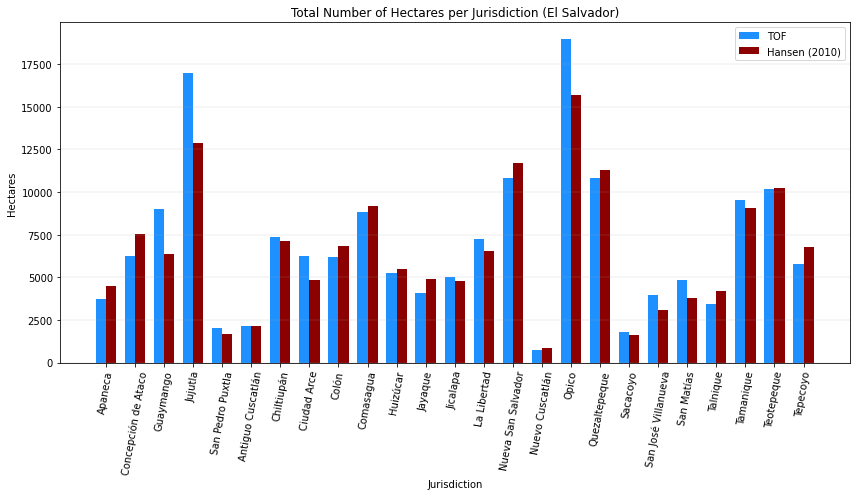

In [189]:
labels = list(tvh.jurisdiction)[:25]
x = np.arange(len(labels))  
width = 0.35  # the width of the bars

plt.figure(figsize=(12,7))
plt.bar(x - width/2, tvh.tof_total_ha[:25], width, label='TOF', color='dodgerblue')
plt.bar(x + width/2, tvh.hansen_total_ha[:25], width, label='Hansen (2010)', color='darkred')

plt.ylabel('Hectares')
plt.xlabel('Jurisdiction')
plt.title('Total Number of Hectares per Jurisdiction (El Salvador)')
plt.xticks(x, labels=labels, rotation=80)
plt.legend()
plt.grid(axis='y', linewidth=.2)

plt.tight_layout();

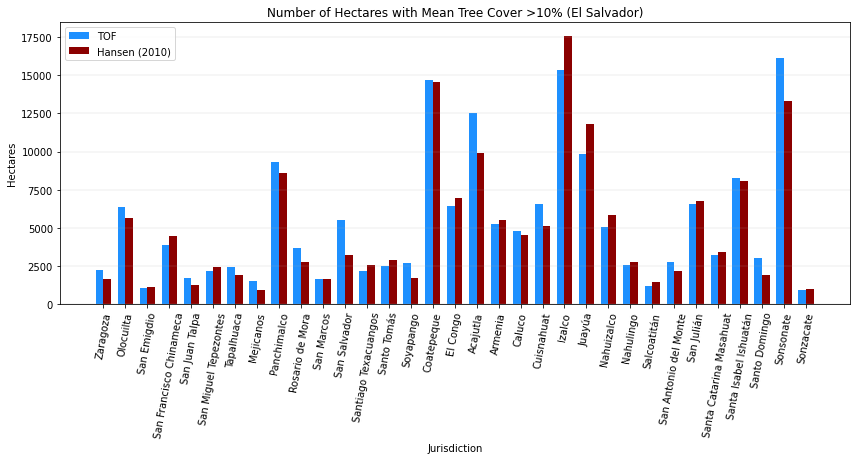

In [190]:
labels = list(tvh.jurisdiction)[25:]
x = np.arange(len(labels))  
width = 0.35  # the width of the bars

plt.figure(figsize=(12,6.5))
plt.bar(x - width/2, tvh.tof_total_ha[25:], width, label='TOF', color='dodgerblue')
plt.bar(x + width/2, tvh.hansen_total_ha[25:], width, label='Hansen (2010)', color='darkred')

plt.ylabel('Hectares')
plt.xlabel('Jurisdiction')
plt.title('Number of Hectares with Mean Tree Cover >10% (El Salvador)')
plt.xticks(x, labels=labels, rotation=80)
plt.legend()
plt.grid(axis='y', linewidth=.2)

plt.tight_layout();

In [193]:
# where does TOF see the biggest difference?
tvh.sort_values(by='tof_hans', ascending=False)[:5]

,jurisdiction,tof_mean_tc,tof_total_ha,hansen_mean_tc,hansen_total_ha,tof_hans
3,Jujutla,26.606,16974,14.555,12873,4101
16,Opico,23.850,18996,13.947,15663,3333
56,Sonsonate,16.146,16138,8.850,13286,2852
2,Guaymango,27.645,9031,12.511,6376,2655
42,Acajutla,14.289,12509,8.300,9899,2610


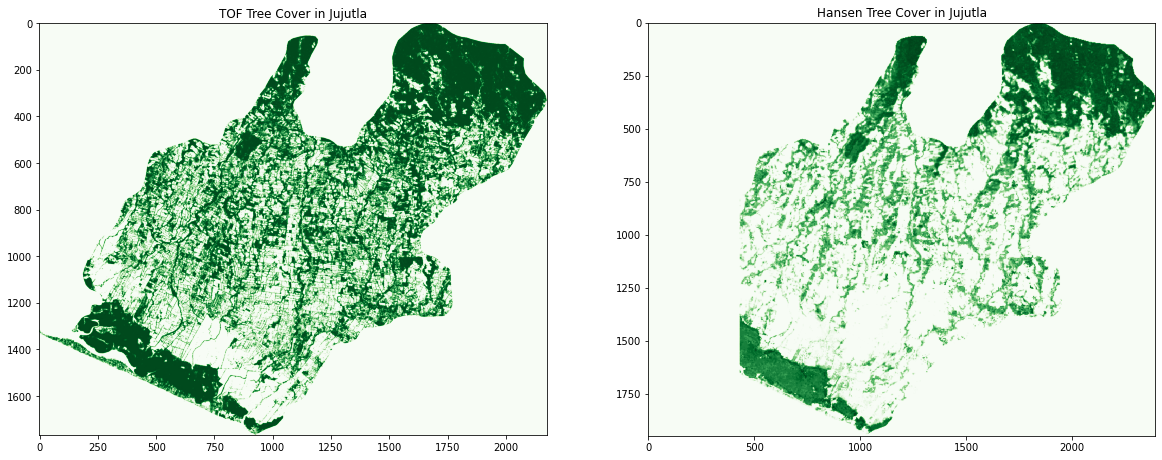

In [199]:
jujutla_tof = rs.open('El Salvador/resampled_rasters/tof/Jujutla.tif').read(1)
jujutla_han = rs.open('El Salvador/resampled_rasters/hansen/Jujutla.tif').read(1)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(jujutla_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Tree Cover in Jujutla')

plt.subplot(1,2,2)
plt.imshow(jujutla_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Jujutla')


plt.tight_layout;

In [194]:
# where does Hansen see the biggest difference?
tvh.sort_values(by='tof_hans', ascending=True)[:5]

,jurisdiction,tof_mean_tc,tof_total_ha,hansen_mean_tc,hansen_total_ha,tof_hans
46,Izalco,29.280,15315,24.869,17575,-2260
47,Juayúa,51.107,9832,47.523,11779,-1947
1,Concepción de Ataco,61.418,6281,58.504,7555,-1274
24,Tepecoyo,53.441,5813,49.233,6774,-961
14,Nueva San Salvador,28.830,10850,23.222,11699,-849


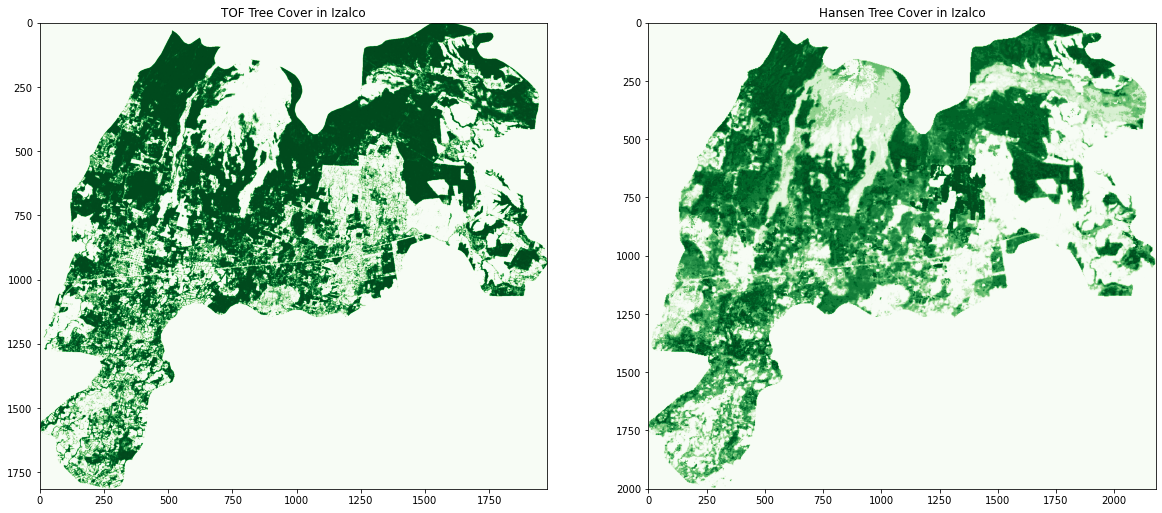

In [200]:
izalco_tof = rs.open('El Salvador/resampled_rasters/tof/Izalco.tif').read(1)
izalco_han = rs.open('El Salvador/resampled_rasters/hansen/Izalco.tif').read(1)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(izalco_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Tree Cover in Izalco')

plt.subplot(1,2,2)
plt.imshow(izalco_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Izalco')


plt.tight_layout;

## ESA Land Cover Classes

**Questions for EDA and potential visualizations**
- Which land cover classes have the highest mean tree cover in [country] according to TOF and Hansen? Highest number of hectares? 
- What are the most popular land cover classes in El Salvador?
- Are the differences between TOF and Hansen particular to certain land cover classes? Where do they disagree most? Agree most?
- What does tree cover look like in the "No Data" land cover class?
- Can we overlay a map of the tree cover with land cover classes?

In [137]:
# define color palette
colors = ['royalblue','maroon', 'gray', 'sandybrown', 
          'gold', 'limegreen', 'green', 'palevioletred',
          'mediumturquoise', 'red', 'cyan', 'sienna', 'navy', 
          'mediumpurple', 'darkkhaki', 'magenta']

### Most Popular ESA Classes
What are the most popular land cover classes?

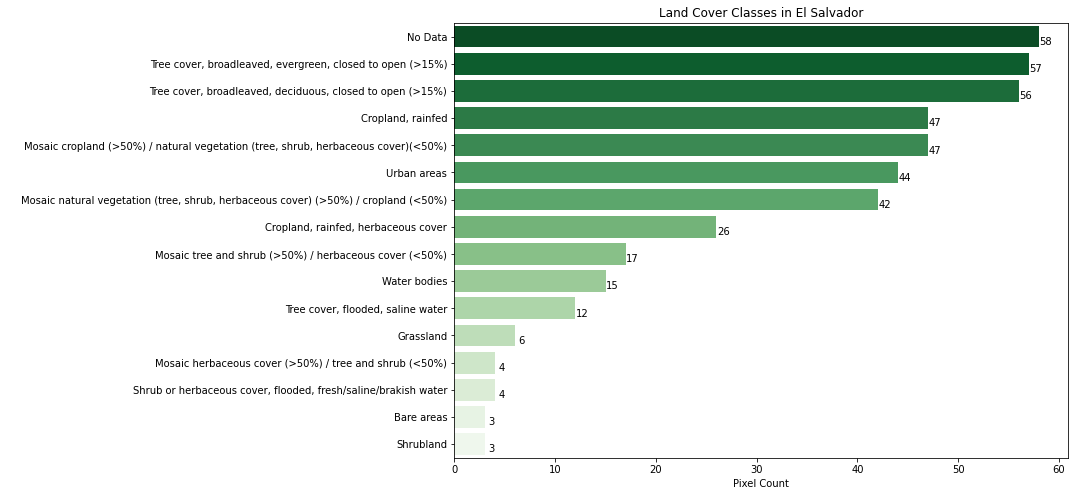

In [49]:
fig, ax = plt.subplots(figsize=(11,8))
sns.countplot(y='lc_class',
              data=landcover,
              palette='Greens_r',
              order=landcover.lc_class.value_counts().index,
              ax=ax)

for p, label in zip(ax.patches, landcover['lc_class'].value_counts(ascending=False)):
    x = p.get_x() + p.get_width() + 0.7
    y = p.get_y() + p.get_height()/2
    ax.annotate(label, (x,y), ha='center', va='top')

ax.set_title('Land Cover Classes in El Salvador')
ax.set_xlabel('Pixel Count')
ax.set_ylabel(' ');

### TOF vs Hansen Tree Cover per Land Cover Class

Compare TOF and Hansen tree cover estimates for each ESA and IPCC land cover class. Which land cover classes have the highest mean tree cover according to TOF and Hansen? Which have the highest number of hectares? 

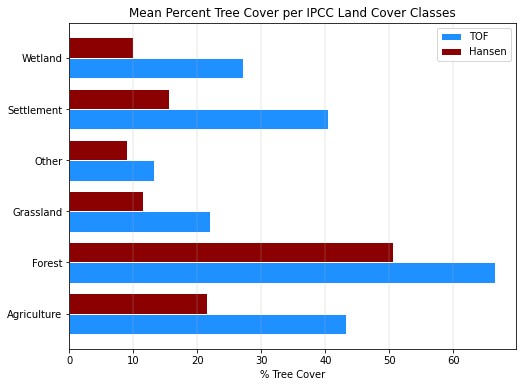

In [126]:
mean_per_ipcc = landcover[['tof_mean_tc', 
                           'hansen_mean_tc', 
                           'ipcc_class']].groupby('ipcc_class').mean().reset_index()
plt.figure(figsize=(8,6))

width = 0.4
pos1 = np.arange(len(mean_per_ipcc))
pos2 = pos1 + width

plt.barh(pos1, mean_per_ipcc['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, mean_per_ipcc['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, mean_per_ipcc['ipcc_class'].values)

plt.legend()
plt.title('Mean Percent Tree Cover per IPCC Land Cover Classes')
plt.grid(axis='x', linestyle='-', linewidth=.3);


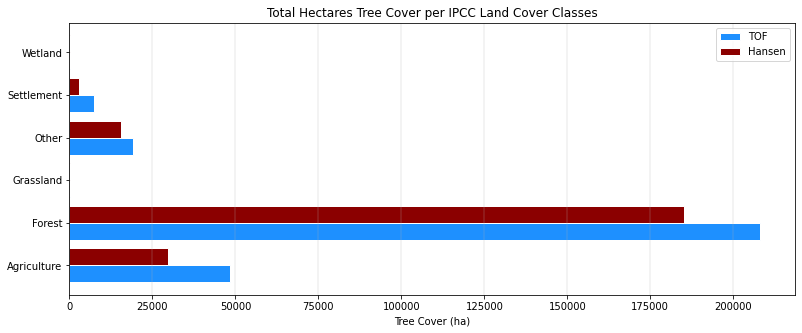

In [132]:
ha_per_ipcc = landcover[['tof_total_ha', 
                        'hansen_total_ha', 
                        'ipcc_class']].groupby('ipcc_class').sum().reset_index()

plt.figure(figsize=(13,5))

width = 0.4
pos1 = np.arange(len(ha_per_ipcc))
pos2 = pos1 + width

plt.barh(pos1, ha_per_ipcc['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_ipcc['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_ipcc['ipcc_class'].values)

plt.legend()
plt.title('Total Hectares Tree Cover per IPCC Land Cover Classes')
plt.grid(axis='x', linestyle='-', linewidth=.3);


In [121]:
ha_per_lc = landcover[['tof_total_ha', 
                       'hansen_total_ha', 
                       'lc_class']].groupby('lc_class').sum().sort_values('tof_total_ha').reset_index()

mean_per_lc = landcover[['tof_mean_tc', 
                       'hansen_mean_tc', 
                       'lc_class']].groupby('lc_class').mean().sort_values('tof_mean_tc').reset_index()

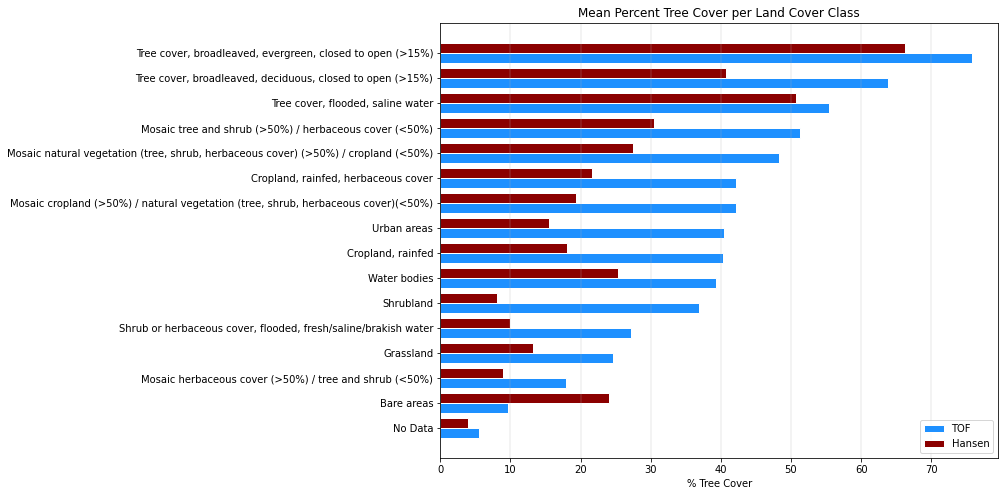

In [122]:
plt.figure(figsize=(10,8))

width = 0.4
pos1 = np.arange(len(mean_per_lc))
pos2 = pos1 + width

plt.barh(pos1, mean_per_lc['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, mean_per_lc['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, mean_per_lc['lc_class'].values)

plt.legend()
plt.title('Mean Percent Tree Cover per Land Cover Class')
plt.grid(axis='x', linestyle='-', linewidth=.3);

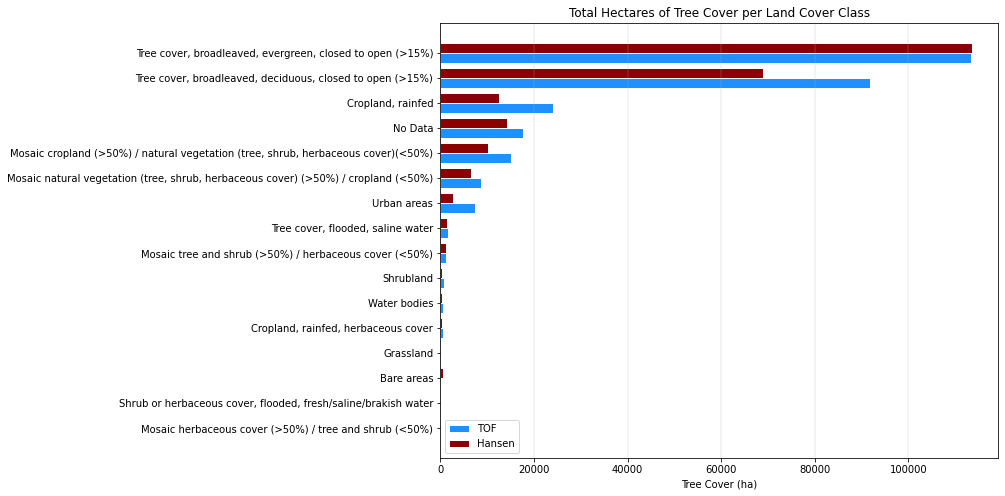

In [123]:
plt.figure(figsize=(10,8))

width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(len(ha_per_lc))
pos2 = pos1 + width

plt.barh(pos1, ha_per_lc['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_lc['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_lc['lc_class'].values)
 
# Create legend & Show graphic
plt.legend()
plt.title('Total Hectares of Tree Cover per Land Cover Class')
plt.grid(axis='x', linestyle='-', linewidth=.3);

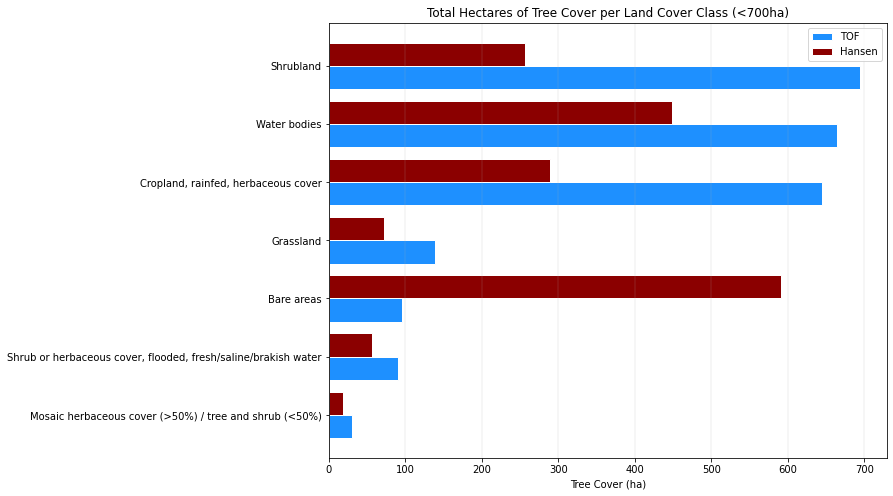

In [124]:
# zoom in on land categories with smaller count

plt.figure(figsize=(10,8))

width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(0,7)
pos2 = pos1 + width

plt.barh(pos1, ha_per_lc['tof_total_ha'][:7], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_lc['hansen_total_ha'][:7], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_lc['lc_class'].values[:7])
 
# Create legend & Show graphic
plt.legend()
plt.title('Total Hectares of Tree Cover per Land Cover Class (<700ha)')
plt.grid(axis='x', linestyle='-', linewidth=.2);

### Tree Cover in No Data Class
What does tree cover look like in ESA's "No Data" class?

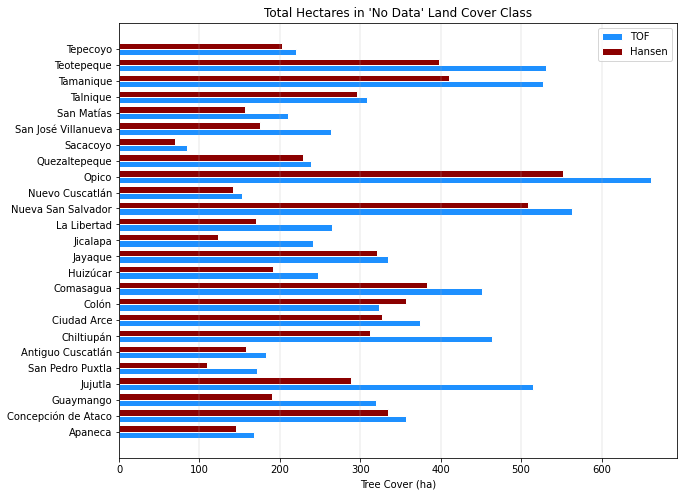

In [181]:
no_data25 = landcover[landcover.lc_class == 'No Data'][:25]

plt.figure(figsize=(10,8))
width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(len(no_data25))
pos2 = pos1 + width

plt.barh(pos1, no_data25['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, no_data25['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, no_data25['jurisdiction'].values)
 
# Create legend & Show graphic
plt.legend()
plt.title("Total Hectares in 'No Data' Land Cover Class")
plt.grid(axis='x', linestyle='-', linewidth=.3);

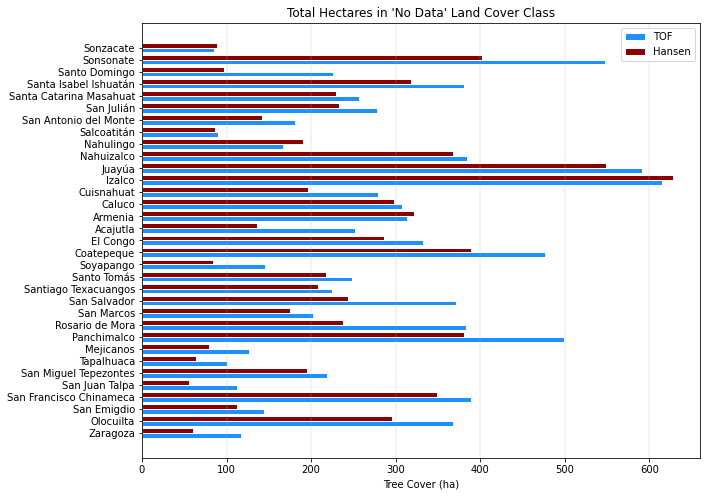

In [187]:
no_data33 = landcover[landcover.lc_class == 'No Data'][25:]

plt.figure(figsize=(10,8))
width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(len(no_data33))
pos2 = pos1 + width

plt.barh(pos1, no_data33['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, no_data33['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, no_data33['jurisdiction'].values)
 
# Create legend & Show graphic
plt.legend()
plt.title("Total Hectares in 'No Data' Land Cover Class")
plt.grid(axis='x', linestyle='-', linewidth=.3);

### Average and Total Difference per Class
What is the average and total difference between TOF and Hansen tree cover estimates?

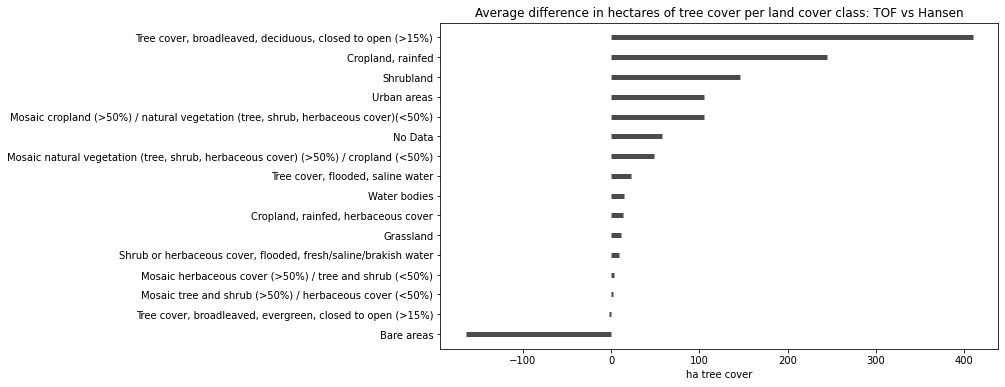

In [18]:
# Plots the average difference between total hecatares of tof and hansen for each land cover class
# the tof_hans column is calculated by tof total ha - hansen total ha

diverge_mean = landcover.groupby('lc_class')['tof_hans'].mean().sort_values().reset_index()
diverge_sum = landcover.groupby('lc_class')['tof_hans'].sum().sort_values().reset_index()
colors = ['red' if x < 0 else 'green' for x in diverge_mean.tof_hans]

plt.figure(figsize=(10,6))

plt.hlines(y=diverge_mean.lc_class, 
           xmin=0, 
           xmax=diverge_mean.tof_hans, 
           alpha=0.7,
           linewidth=5)

plt.title('Average difference in hectares of tree cover per land cover class: TOF vs Hansen')
plt.xlabel('ha tree cover');

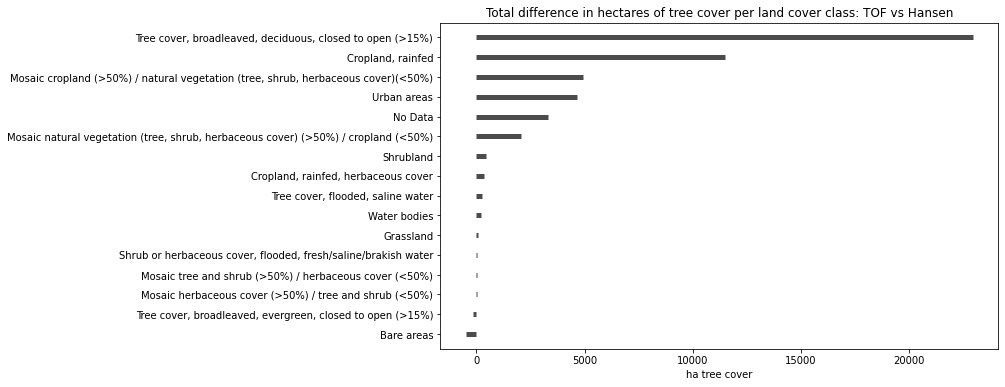

In [19]:
plt.figure(figsize=(10,6))

plt.hlines(y=diverge_sum.lc_class, 
           xmin=0, 
           xmax=diverge_sum.tof_hans, 
           alpha=0.7,
           linewidth=5)

plt.title('Total difference in hectares of tree cover per land cover class: TOF vs Hansen')
plt.xlabel('ha tree cover');

### Total Hectares per Class: Hansen v TOF
What does the distribution look like across all land cover classes?

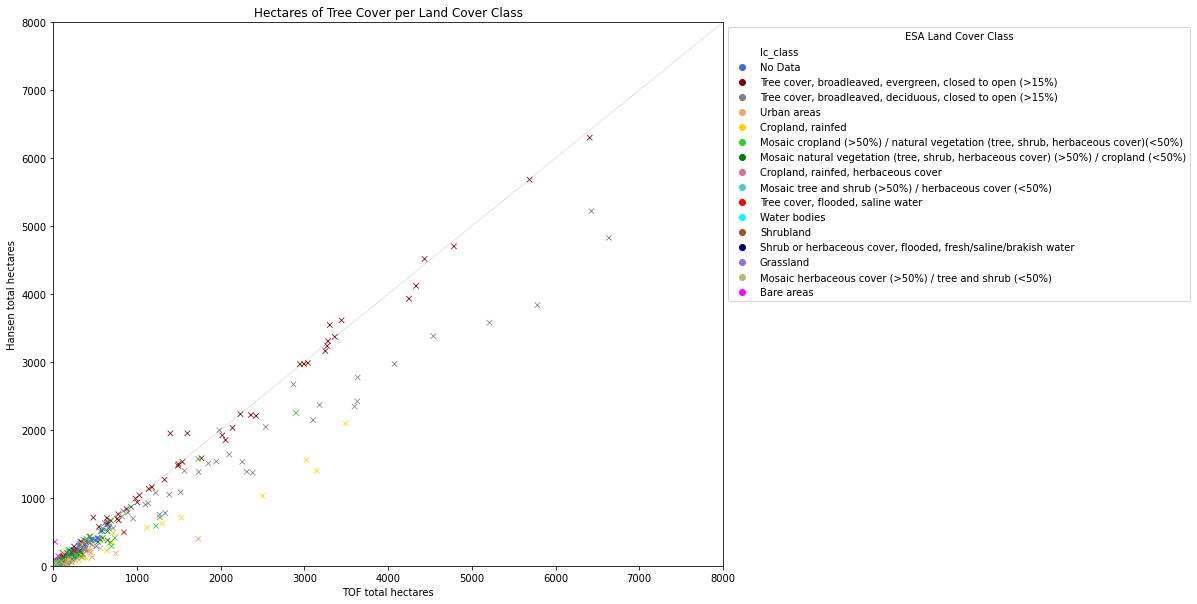

In [138]:
# All land cover classes 
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=landcover, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 8000), ylim=(0, 8000))
ax.plot(np.arange(0.001, 8000, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')


plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

In [140]:
under500 = landcover[(landcover.tof_total_ha <= 500) & (landcover.hansen_total_ha <= 500)]
under2k = landcover[(landcover.tof_total_ha <= 2000) & (landcover.hansen_total_ha <= 2000)]

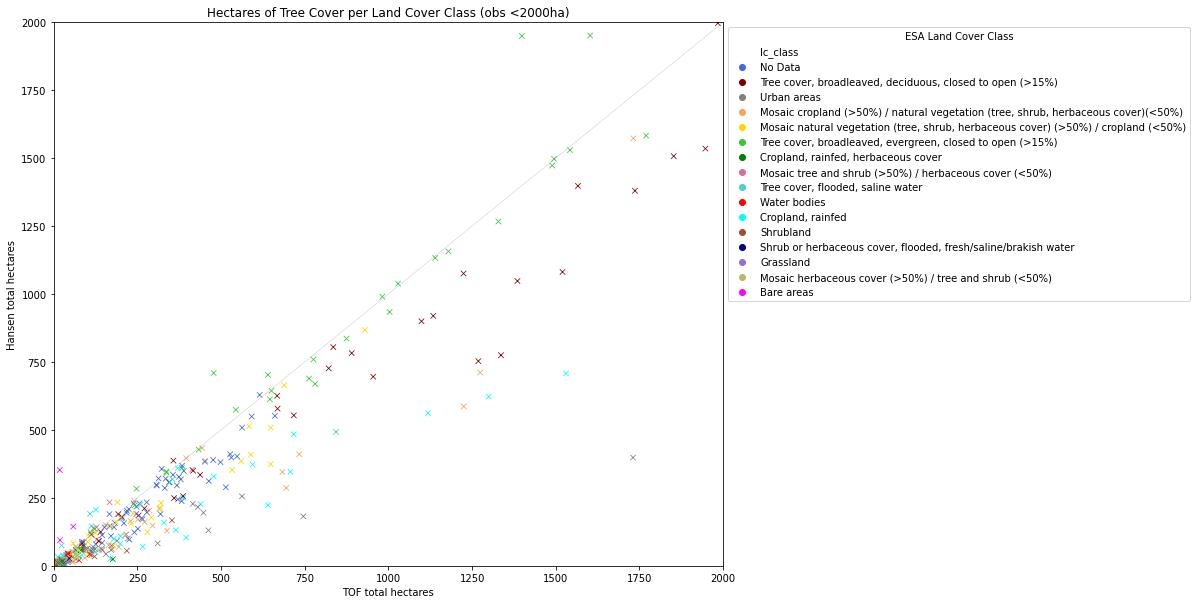

In [141]:
# All land cover classes for obs <2000ha
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=under2k, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 2000), ylim=(0, 2000))
ax.plot(np.arange(0.001, 3000, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class (obs <2000ha)')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')


plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

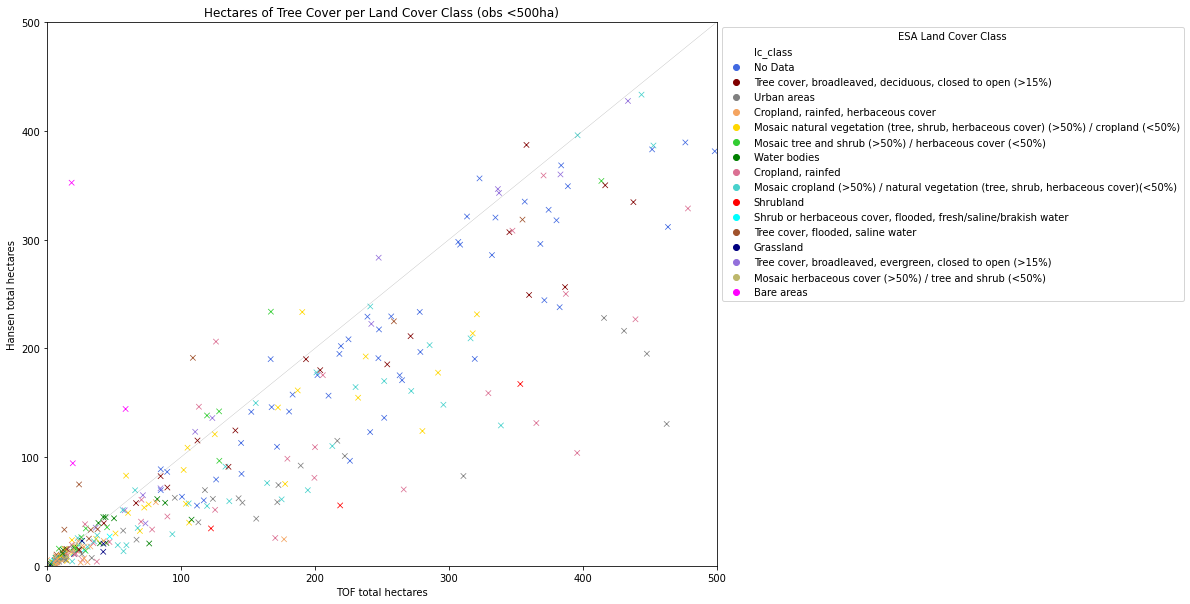

In [142]:
# All land cover classes for obs <500ha
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=under500, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 500), ylim=(0, 500))
ax.plot(np.arange(0.001, 500, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class (obs <500ha)')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')

plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

In [143]:
forest = landcover[landcover.ipcc_class == 'Forest']
agriculture = landcover[landcover.ipcc_class == 'Agriculture']
settlement = landcover[landcover.ipcc_class == 'Settlement']
grassland = landcover[landcover.ipcc_class == 'Grassland']
wetland = landcover[landcover.ipcc_class == 'Wetland']
other = landcover[landcover.ipcc_class == 'Other']

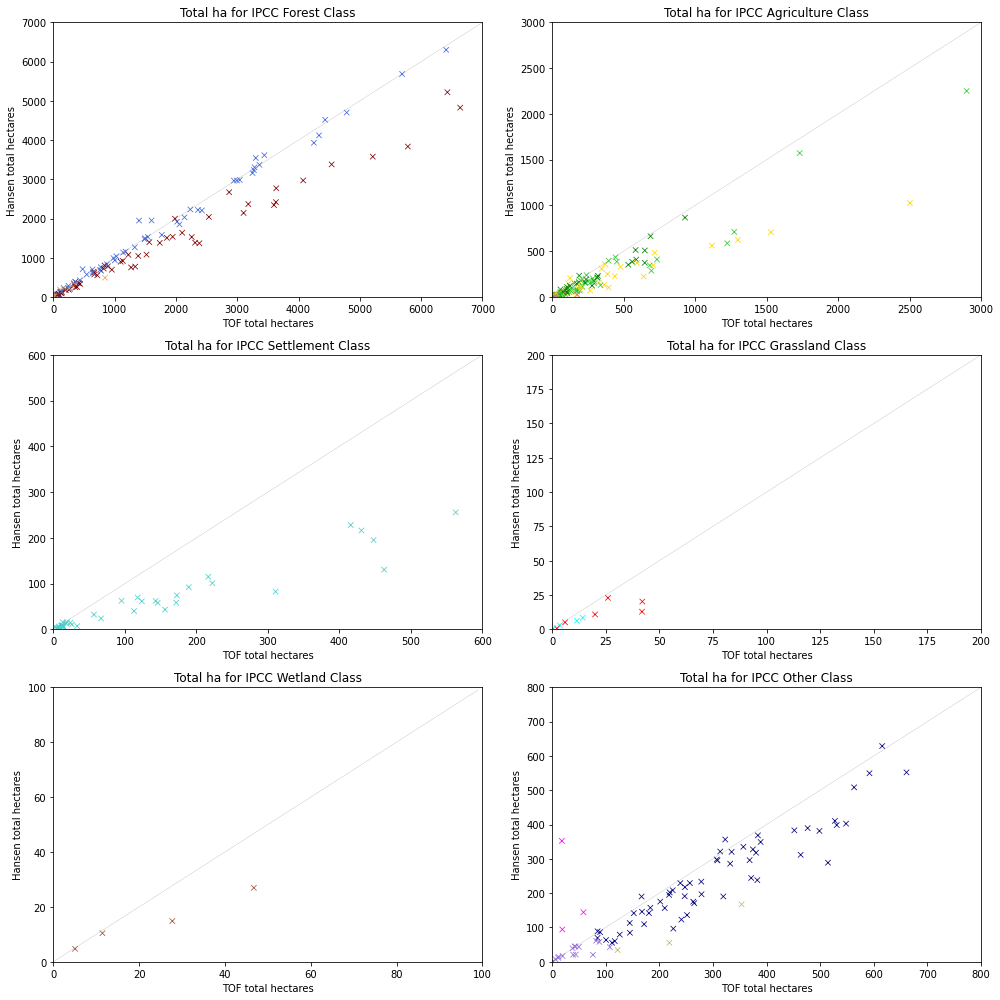

In [169]:
# update these groupings to be for ipcc classes?
plt.figure(figsize=(14,14))

ax1 = plt.subplot(3,2,1)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=forest, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[:4],
               ax=ax1,
               legend=False)
ax1.set(xlim=(0, 7000), ylim=(0, 7000))
ax1.plot(np.arange(0.001, 8000, 1), color='grey', linewidth=.2)
ax1.set_title('Total ha for IPCC Forest Class')
ax1.set_xlabel('TOF total hectares')
ax1.set_ylabel('Hansen total hectares')

ax2 = plt.subplot(3,2,2)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=agriculture, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[4:8],
               ax=ax2,
               legend=False)
ax2.set(xlim=(0, 3000), ylim=(0, 3000))
ax2.plot(np.arange(0.001, 3000, 1), color='grey', linewidth=.2)
ax2.set_title('Total ha for IPCC Agriculture Class')
ax2.set_xlabel('TOF total hectares')
ax2.set_ylabel('Hansen total hectares')


ax3 = plt.subplot(3,2,3)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=settlement, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[8:9],
               ax=ax3,
               legend=False)
ax3.set(xlim=(0, 600), ylim=(0, 600))
ax3.plot(np.arange(0.001, 700, 1), color='grey', linewidth=.2)
ax3.set_title('Total ha for IPCC Settlement Class')
ax3.set_xlabel('TOF total hectares')
ax3.set_ylabel('Hansen total hectares')

ax4 = plt.subplot(3,2,4)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=grassland, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[9:11],
               ax=ax4,
               legend=False)
ax4.set(xlim=(0, 200), ylim=(0, 200))
ax4.plot(np.arange(0.001, 1000, 1), color='grey', linewidth=.2)
ax4.set_title('Total ha for IPCC Grassland Class')
ax4.set_xlabel('TOF total hectares')
ax4.set_ylabel('Hansen total hectares')

ax5 = plt.subplot(3,2,5)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=wetland, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[11:12],
               ax=ax5,
               legend=False)
ax5.set(xlim=(0, 100), ylim=(0, 100))
ax5.plot(np.arange(0.001, 100, 1), color='grey', linewidth=.2)
ax5.set_title('Total ha for IPCC Wetland Class')
ax5.set_xlabel('TOF total hectares')
ax5.set_ylabel('Hansen total hectares')

ax6 = plt.subplot(3,2,6)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=other, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[12:],
               ax=ax6,
               legend=False)
ax6.set(xlim=(0, 800), ylim=(0, 800))
ax6.plot(np.arange(0.001, 800, 1), color='grey', linewidth=.2)
ax6.set_title('Total ha for IPCC Other Class')
ax6.set_xlabel('TOF total hectares')
ax6.set_ylabel('Hansen total hectares')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.tight_layout();


### Clipped & Resampled Jurisdictional Rasters

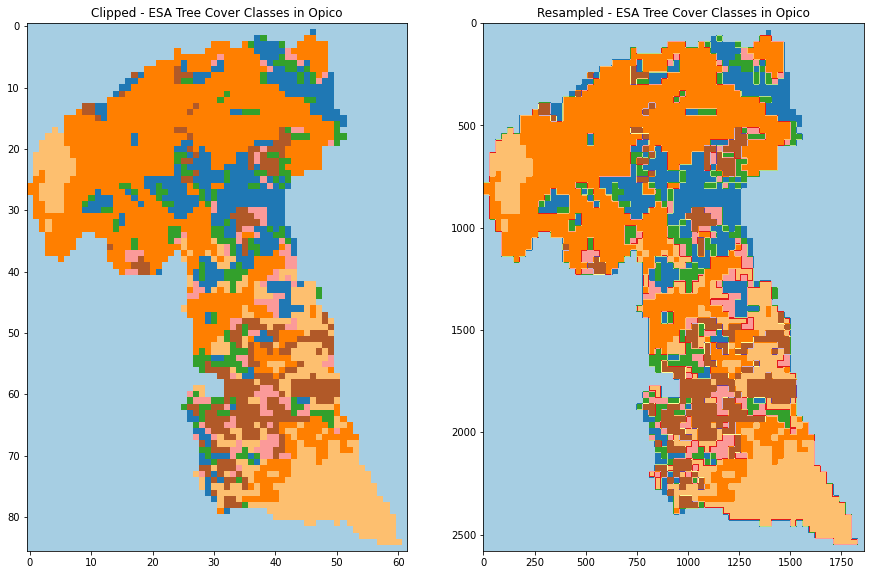

In [52]:
plt.figure(figsize=(15,10))

opico_esa_resampled = rs.open('resampled_rasters/esa/Opico.tif').read(1)
opico_esa_clipped = rs.open('clipped_rasters/esa/Opico.tif').read(1)

plt.subplot(1,2,1)
plt.imshow(opico_esa_clipped, cmap='Paired', vmin=0, vmax=100)
plt.title('Clipped - ESA Tree Cover Classes in Opico')

plt.subplot(1,2,2)
plt.imshow(opico_esa_resampled, cmap='Paired', vmin=0, vmax=100)
plt.title('Resampled - ESA Tree Cover Classes in Opico')

plt.tight_layout;

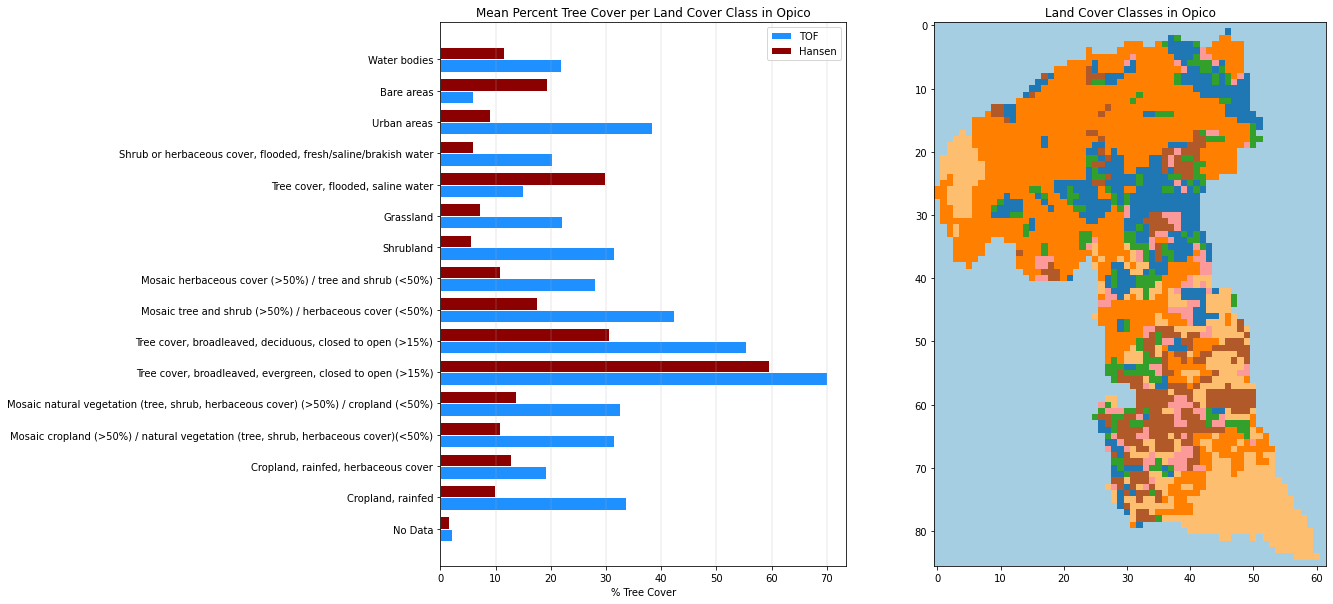

In [229]:
plt.figure(figsize=(16,10))
opico_esa = rs.open('El Salvador/clipped_rasters/esa/Opico.tif').read(1)
opico = landcover[landcover.jurisdiction == 'Opico']

ax1 = plt.subplot(1,2,1)

width = 0.4
pos1 = np.arange(len(opico))
pos2 = pos1 + width

ax1.barh(pos1, opico['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
ax1.barh(pos2, opico['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, opico['lc_class'].values)

plt.legend()
ax1.set_title('Mean Percent Tree Cover per Land Cover Class in Opico')
plt.grid(axis='x', linestyle='-', linewidth=.3)

ax2 = plt.subplot(1,2,2)
ax2.imshow(opico_esa, cmap='Paired', vmin=0, vmax=100)
ax2.set_title('Land Cover Classes in Opico');
